In [3]:
import pandas as pd
import logging
from Utils.async_wiki import async_check_companies

In [2]:
orgs = pd.read_csv('csvs/orgs_ibm_checked.csv')

In [3]:
uniq_orgs = orgs['organization'].unique()

In [4]:
from time import time
import csv

In [6]:
OUTPUT_FILE = 'wikidata_cleaned.csv'

In [7]:
def reset_org_file():
    with open(OUTPUT_FILE, 'w', encoding='utf8') as wiki_file:
        writer = csv.DictWriter(wiki_file, fieldnames=['name', 'label','is_company'])
        writer.writeheader()

In [11]:
#reset_org_file()

In [8]:
def write_orgs(orgs):
    with open(OUTPUT_FILE,'a',encoding='utf8') as orgs_file:
        field_names = ['name', 'label','is_company']
        writer = csv.DictWriter(orgs_file,fieldnames=field_names)
        for org_name, org_params in parsed_orgs.items():
            if org_params:
                to_write = {
                    'name': org_name,
                    'label':org_params[0]['label'],
                    'is_company': org_params[0]['is_company'],
                } 
                
            else:
                to_write = {
                    'name': org_name,
                    'label':None,
                    'is_company': False,
                } 
            
            writer.writerow(to_write)

In [9]:
logging.basicConfig(level=logging.INFO)

In [13]:
done_orgs = pd.read_csv(OUTPUT_FILE)
done_org_names = set(done_orgs['name'].unique())
orgs_to_check = [org for org in uniq_orgs if org not in done_org_names]

total = len(orgs_to_check)
step = min(300, total)
start = time()
for i in range(0,total,step):
    logging.info(f'New batch ({i}:{i+step}) started')
    parsed_orgs = dict()
    batch_start = time()
    batch = orgs_to_check[i:i+step]
    result = await async_check_companies(batch, 150)
    for index,name in enumerate(batch):
        parsed_orgs[name] = result[index]
    write_orgs(parsed_orgs)
    logging.info(
        f'{i+step} of {total} processed\n'
        f'Batch time: {time()-batch_start} s\n'
        f'Total time: {time()-start} s\n'
    )

INFO:root:New batch (0:300) started


INFO:root:300 of 3000 processed
Batch time: 3.7318038940429688 s
Total time: 3.733423948287964 s

INFO:root:New batch (300:600) started


INFO:root:600 of 3000 processed
Batch time: 3.477337121963501 s
Total time: 7.212873220443726 s

INFO:root:New batch (600:900) started


INFO:root:900 of 3000 processed
Batch time: 2.726851224899292 s
Total time: 9.941595077514648 s

INFO:root:New batch (900:1200) started


INFO:root:1200 of 3000 processed
Batch time: 3.5614356994628906 s
Total time: 13.504846334457397 s

INFO:root:New batch (1200:1500) started


INFO:root:1500 of 3000 processed
Batch time: 3.4268367290496826 s
Total time: 16.934219121932983 s

INFO:root:New batch (1500:1800) started


ERROR:root:High level exception
Traceback (most recent call last):
  File "/home/pontianak/data/OneDrive/Study/lp_tmp/corporate_sentiment/data/async_wiki.py", line 187, in async_check_companies
    batch_result = await asyncio.gather(*tasks)
  File "/home/pontianak/data/OneDrive/Study/lp_tmp/corporate_sentiment/data/async_wiki.py", line 148, in async_check_company
    entities_json = await async_get_entity(session,entities_codes)
  File "/home/pontianak/data/OneDrive/Study/lp_tmp/corporate_sentiment/data/async_wiki.py", line 128, in async_get_entity
    data = await response.json()
  File "/home/pontianak/.local/lib/python3.8/site-packages/aiohttp/client_reqrep.py", line 1026, in json
    raise ContentTypeError(
aiohttp.client_exceptions.ContentTypeError: 0, message='Attempt to decode JSON with unexpected mimetype: text/html; charset=utf-8', url=URL('https://www.wikidata.org/w/api.php?action=wbgetentities&sites=enwiki&languages=en&format=json&ids=Q30284052&props=labels%7Cclaims')


INFO:root:1800 of 3000 processed
Batch time: 14.88580870628357 s
Total time: 31.8224835395813 s

INFO:root:New batch (1800:2100) started


INFO:root:2100 of 3000 processed
Batch time: 2.6369616985321045 s
Total time: 34.462566614151 s

INFO:root:New batch (2100:2400) started


INFO:root:2400 of 3000 processed
Batch time: 2.9876582622528076 s
Total time: 37.45221829414368 s

INFO:root:New batch (2400:2700) started


INFO:root:2700 of 3000 processed
Batch time: 3.0141549110412598 s
Total time: 40.46780037879944 s

INFO:root:New batch (2700:3000) started


INFO:root:3000 of 3000 processed
Batch time: 2.6795105934143066 s
Total time: 43.149012327194214 s



In [3]:
cleaned_orgs = pd.read_csv(OUTPUT_FILE)

In [4]:
true_orgs = cleaned_orgs[cleaned_orgs['is_company']].copy()

In [31]:
orgs = orgs.join(true_orgs.set_index('name'),on='organization', how='left')

In [33]:
orgs.dropna(subset=['is_company'],inplace=True)

In [40]:
count_org_in_doc = orgs.groupby(by='uuid').agg({'organization': 'count'})

In [44]:
count_dict = count_org_in_doc['organization'].T.to_dict()

In [48]:
orgs['orgs_in_doc'] = orgs['uuid'].apply(lambda uuid: count_dict[uuid])

In [55]:
orgs.drop('is_company',axis=1,inplace=True)

In [56]:
orgs.to_csv('orgs_ibm_wiki_cleaned.csv', index=False)

In [59]:
unique_uuids = set(orgs.uuid.unique())

In [63]:
docs = pd.read_csv('csvs/docs_for_normalized_orgs.csv')

In [69]:
docs = docs[docs['uuid'].isin(unique_uuids)].copy()

In [72]:
docs.to_csv('docs_ibm_wiki_cleaned.csv', index=False)

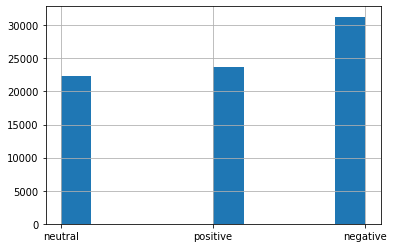

In [79]:
orgs[(orgs['orgs_in_doc'] <= 5) & (orgs['confidence']>=0.6)].sentiment_label.hist()